# Соревнование: San Francisco Crime Classification

_Given time and location, you must predict the category of crime that occurred. Kaggle is hosting this competition for the machine learning community to use for fun and practice._

https://www.kaggle.com/c/sf-crime

## 1. Подготовка работы. Загрузка библиотек и настройка отображения
Импорты и настроийки, которые необходимы для шаблона.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

%matplotlib inline

## 2. Загрузка, очистка данных. Exploratory data analysis.

Загрузка тренировочных данных из csv:

In [2]:
train_data = pd.read_csv('data/train.csv')

Просмотрим структуру данных:

In [3]:
train_data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


Целевая переменная находится в столбце *Category*, ее и надо будет предсказать.

In [4]:
train_data[['Category', 'Descript','DayOfWeek','PdDistrict','Resolution','Address']].describe()

,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address
count,878049,878049,878049,878049,878049,878049
unique,39,879,7,10,17,23228
top,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST
freq,174900,60022,133734,157182,526790,26533


In [5]:
train_data[['X','Y']].describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


Видно, что есть преступления со странными координатами -120, 90 возможно эти данные были занесены с ошибками. Посчитаем сколько у нас таких данных.

In [6]:
train_data[(train_data['X']==-120.5) & (train_data['Y']==90.0)].shape[0]

67

Всего таких записей 67, поэтому чтобы не портить нам регрессию, просто удалим эти строки.

In [7]:
train_data = train_data[(train_data['X']!=-120.5) | (train_data['Y']!=90.0)]

Немного преобразуем данные, конвертируем строку дата в DateTime объект, а другие столбцы конвертируем в категориальные переменные.

In [8]:
train_data.Dates = pd.to_datetime(train_data.Dates)
train_data.Category = train_data.Category.astype('category')
train_data.Descript = train_data.Descript.astype('category')
train_data.DayOfWeek = train_data.DayOfWeek.astype('category')
train_data.PdDistrict = train_data.PdDistrict.astype('category')
train_data.Resolution = train_data.Resolution.astype('category')
train_data.Address = train_data.Address.astype('category')

Построим гистограмму самых распространненых преступлений:

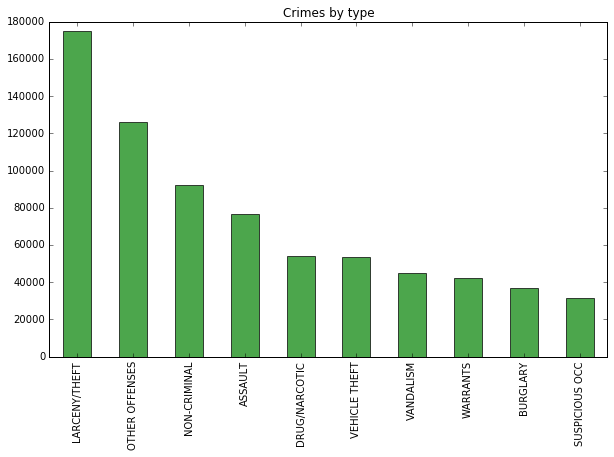

In [9]:
plt.figure(figsize=(10, 6))
train_data.Category.value_counts()[:10].plot(kind='bar', title='Crimes by type', color='green', alpha=0.7)
plt.show()

Остальные преступления:

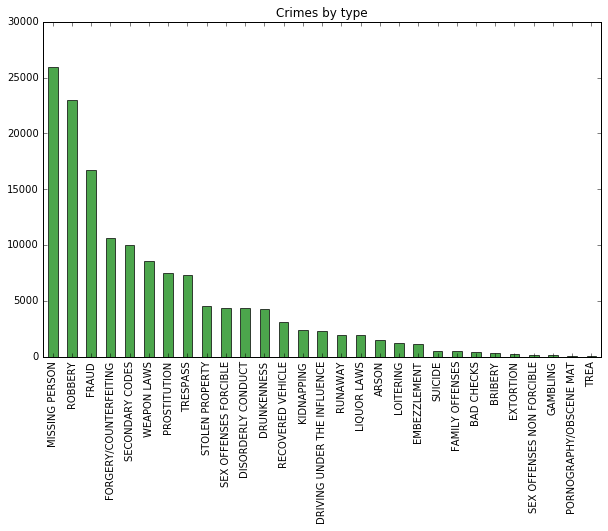

In [10]:
plt.figure(figsize=(10, 6))
train_data.Category.value_counts()[10:].plot(kind='bar', title='Crimes by type', color='green', alpha=0.7)
plt.show()

Разобьем нашу дату на час, день месяца, месяц и год, чтобы получить больше информации:

In [11]:
def convert_time(data):
    data['Hour'] = data.Dates.apply(lambda x: x.hour)
    data['Day'] = data.Dates.apply(lambda x: x.day)
    data['Month'] = data.Dates.apply(lambda x: x.month)
    data['Year'] = data.Dates.apply(lambda x: x.year)
    return data
train_data = convert_time(train_data)

Построим график зависимости количества преступлений от часа дня, дня месяца, дня недели, месяца и года:

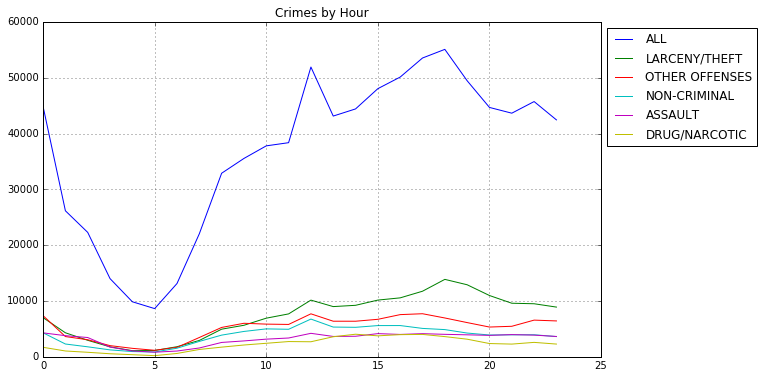

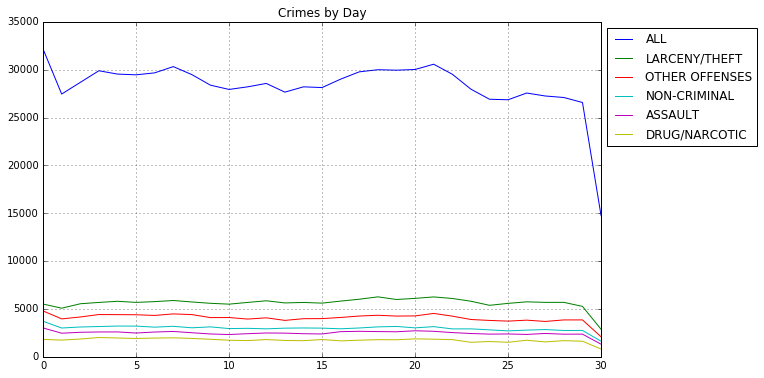

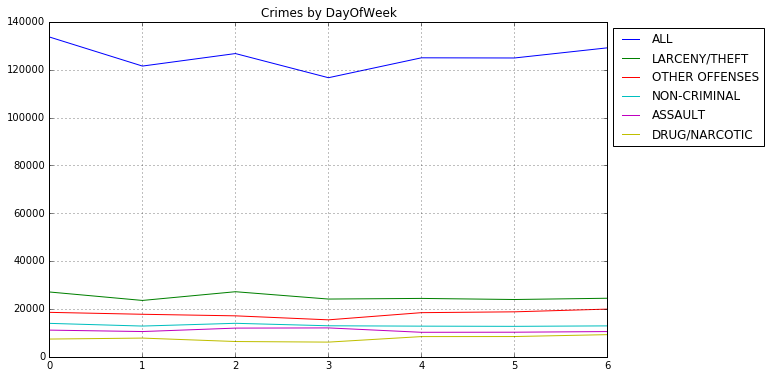

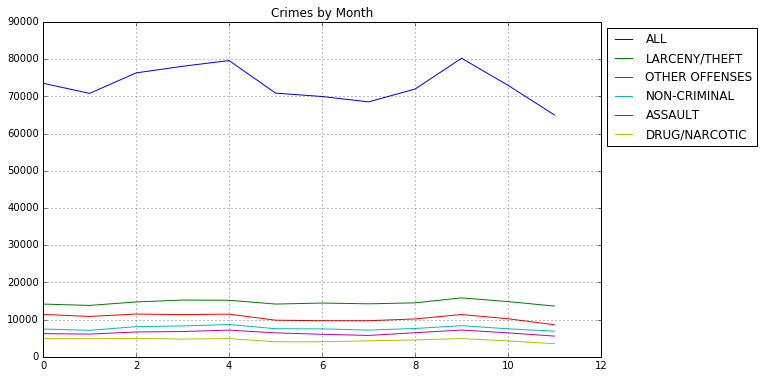

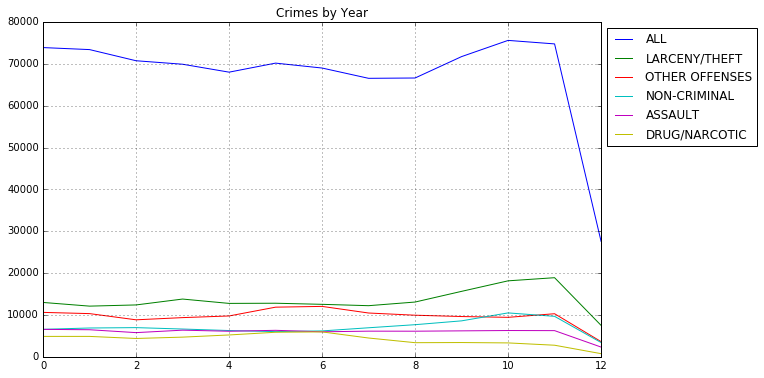

In [12]:
def plot_by_param(param):
    plt.figure(figsize=(10, 6))
    top5_categories = train_data.Category.value_counts().index[:5].tolist()
    plt.plot(train_data[param].value_counts().sort_index().tolist(), label='ALL')
    for cat in top5_categories:
        plt.plot(train_data[train_data.Category==cat][param].value_counts().sort_index().tolist(), label=cat)
    plt.legend(bbox_to_anchor=(1, 1), loc=2,)
    plt.title('Crimes by %s' % (param))
    plt.grid(True)
    
params = ['Hour','Day','DayOfWeek','Month','Year']
for param in params:
    plot_by_param(param)

Видно, что больше всего выражена зависимость числа преступлений от часа суток. Так же есть слабая зависимость некоторых преступлений от дня недели и от года.

Построим теперь карту преступлений:

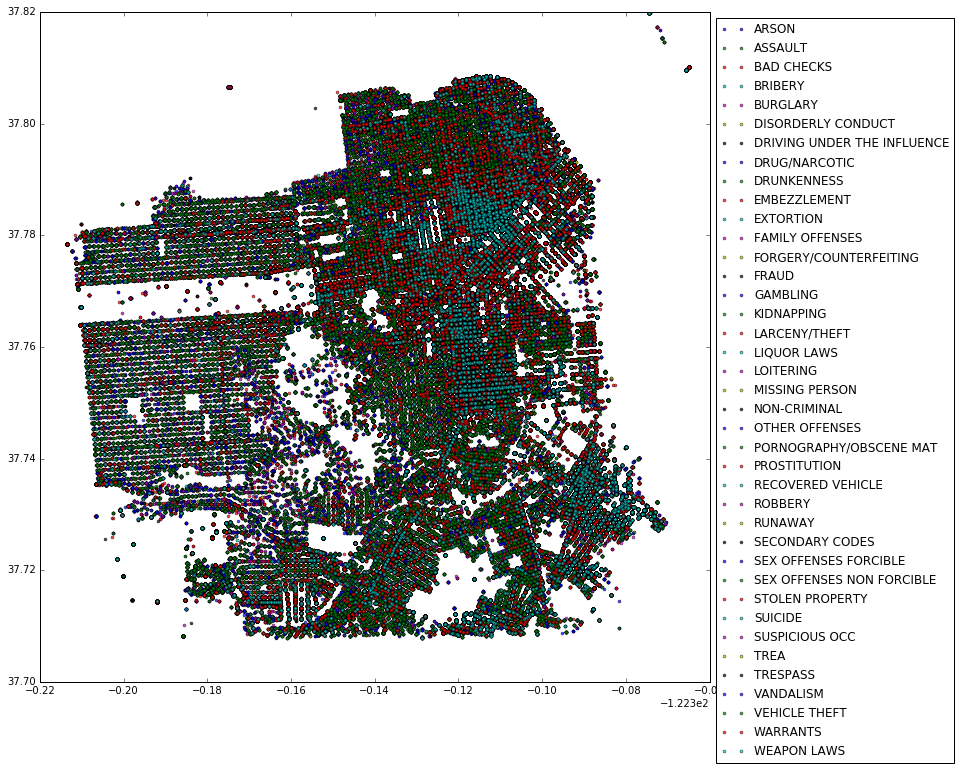

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))
for cat in train_data.Category.cat.categories:
    ax.plot(train_data[train_data.Category==cat].X, train_data[train_data.Category==cat].Y, 
            marker='o', linestyle='', ms=3, alpha=0.7, label = cat)
ax.legend(bbox_to_anchor=(1, 1), loc=2,)

Попробуем построить такую же карту, но возьмем только первые 5 самые популярные виды преступлений:

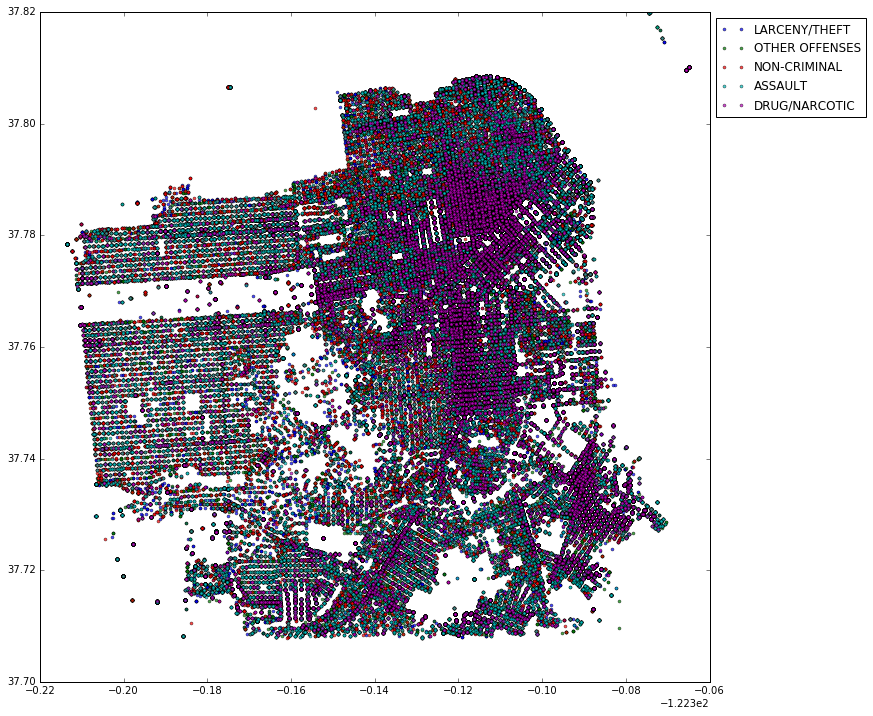

In [14]:
fig, ax = plt.subplots(figsize=(12, 12))
for cat in train_data.Category.value_counts().index[:5].tolist():
    ax.plot(train_data[train_data.Category==cat].X, train_data[train_data.Category==cat].Y, 
            marker='o', linestyle='', ms=3, alpha=0.7, label = cat)
ax.legend(bbox_to_anchor=(1, 1), loc=2,)

Видно, что некоторые преступления сгруппированы в большие кучи, это можно будет использовать.

Построим тепловую карту преступлений:

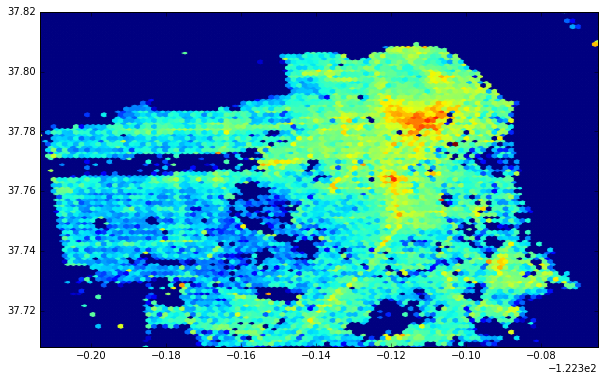

In [15]:
plt.figure(figsize=(10, 6))
plt.hexbin(train_data.X, train_data.Y, bins='log')

Видно, что больше всего преступлений в центре, но пока не особо понятно, как это знание поможет нам определять тип преступления.